In [1]:
#pip install pandas
#pip install gurobipy
#pip install gboml

In [10]:
import gurobipy
from gboml import GbomlGraph
import pandas as pd

# Lastkurve Gas (Daten von Jakob)

- Zusammenschluss von Haushalten und Unternehmen
- Lastkurve für ein Jahr (60 Minuten Zeitschritte)

Gesamtverbrauch 158440730.0


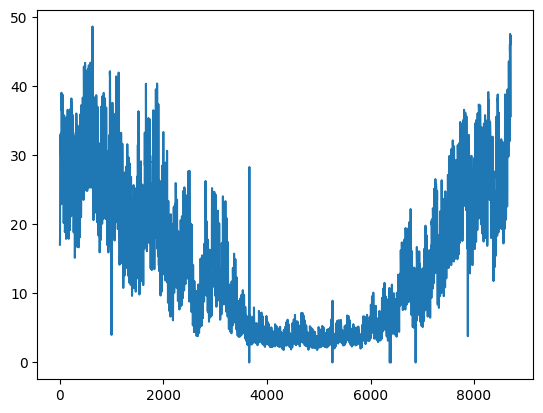

In [13]:
import pickle
with open('../data/example_data/Gas_grid.pkl', 'rb') as f:
    gas_load = pickle.load(f)

gas_load = pd.DataFrame(gas_load)
#gas_load['value'].plot()

print('Gesamtverbrauch', gas_load['value'].sum())
#Gesamtverbrauch besteht aus verschiedenen Unternehmen und Haushalten
#runterskalieren auf 1 Haushalt bzw. kleines Unternehmen (ca. 13.000 kwH pro Jahr)
gesamtlast_gas = gas_load['value'].sum()
gesamtlast_haushalt_gas = 13000*10 #13.000 kWh pro Jahr an Verbrauch
gas_load['HaushaltLastGas'] = gas_load['value'] / gesamtlast_gas * gesamtlast_haushalt_gas
gas_load['HaushaltLastGas'].plot()

#save data as csv
gas_load['HaushaltLastGas'].to_csv("../data/LastprofilHaushaltGas.csv",index=False, header=False)

# check data Jakob

In [7]:
import pickle
import pandas as pd

with open('../data/example_data/Lastreihe.pkl', 'rb') as f: #Lastreihe für? 
    Lastreihe = pickle.load(f)
Lastreihe = pd.DataFrame(Lastreihe)


<Axes: >

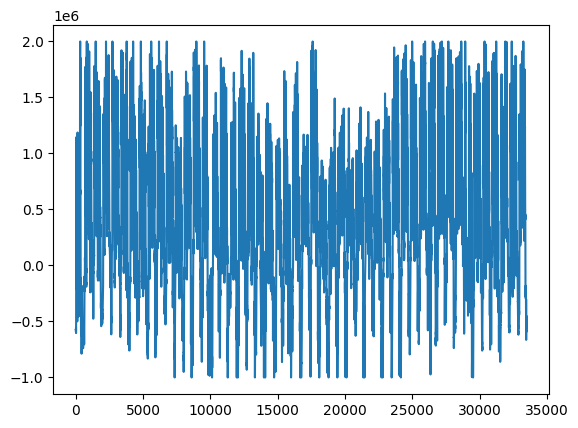

In [10]:
Lastreihe['Lastreihe'].plot()

In [11]:
pd.DataFrame(Lastreihe)

,time,Lastreihe
0,900,-573847.818451
1,1800,-573772.983373
2,2700,-576366.499789
3,3600,-591954.089661
4,4500,-575544.438819
...,...,...
33498,30149100,-544700.061007
33499,30150000,-561734.912946
33500,30150900,-554127.698305
33501,30151800,-563805.702558


# Electricity Prices

In [14]:
#pip install entsoe-py

In [15]:
from entsoe import EntsoePandasClient
from datetime import datetime
import pandas as pd

your_key = '0001b1f3-3601-42e9-b6a7-d359eee34c8d'
country_code = 'DE_LU'  # Germany-Luxembourg
client = EntsoePandasClient(api_key=your_key)

def get_day_a_head_prices(start, end):
    #Returns: Day-Ahead market price array for specified start and end date
    df_prices= pd.DataFrame(client.query_day_ahead_prices(country_code, start=start,end=end))
    df_prices.reset_index(inplace=True)
    df_prices.rename(columns={'index':'DateTime', 0:'Price [EUR/MWh]'}, inplace=True)
    return df_prices

In [16]:
#get electricity prices for 2019
start = pd.Timestamp('20190101', tz='Europe/Brussels')
end = pd.Timestamp('20200101', tz='Europe/Brussels')
electricity_market_prices = get_day_a_head_prices(start, end)
#delete last timestamp to get data from 01.01. 0:00 to 31.12. 23:00
electricity_market_prices = electricity_market_prices[0:electricity_market_prices.shape[0]-1]
#multiply electricity costs by 5 (because of taxes, konzessionsabgabe, netzentgelte, ...)
electricity_market_prices['Price [EUR/MWh]'] = electricity_market_prices['Price [EUR/MWh]'] * 5
electricity_market_prices
#calculate €/kWh
electricity_market_prices['Price [EUR/kWh]'] = electricity_market_prices['Price [EUR/MWh]'] / 1000
print(electricity_market_prices)


                      DateTime  Price [EUR/MWh]  Price [EUR/kWh]
0    2019-01-01 00:00:00+01:00           141.60          0.14160
1    2019-01-01 01:00:00+01:00            50.35          0.05035
2    2019-01-01 02:00:00+01:00           -20.40         -0.02040
3    2019-01-01 03:00:00+01:00           -49.55         -0.04955
4    2019-01-01 04:00:00+01:00           -37.05         -0.03705
...                        ...              ...              ...
8755 2019-12-31 19:00:00+01:00           230.00          0.23000
8756 2019-12-31 20:00:00+01:00           211.00          0.21100
8757 2019-12-31 21:00:00+01:00           198.70          0.19870
8758 2019-12-31 22:00:00+01:00           194.40          0.19440
8759 2019-12-31 23:00:00+01:00           186.95          0.18695

[8760 rows x 3 columns]


<Axes: >

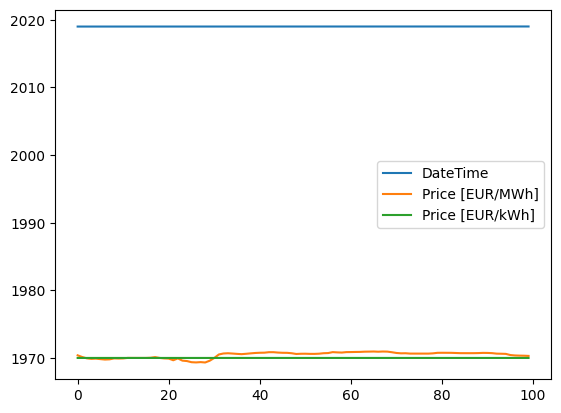

In [17]:
electricity_market_prices[''][0:100].plot()

In [6]:
#save data
electricity_market_prices['Price [EUR/kWh]'].to_csv("../data/electricity_market_prices_2019.csv",index=False, header=False)

# Lastprofil Haushalt Jahresverbrauch: 3500kWh
Vorgehensweise:
- basierend auf dem Datensatz von den Stadtwerken Groß-Gerau wird ein stündliches Lastprofil mit einem Jahresverbrauch von 3500kWh erstellt
- Datensatz: https://www.ggv-energie.de/cms/netz/allgemeine-daten/netzbilanzierung-download-aller-profile.php  
 [GGV_SLP_1000_MWh_2021_01.xlsx (Microsoft Excel)]
- Datensatz enthält die viertelstündliche Last aller Haushalte des Stadtwerks Groß-Gerau
- Berechnung eines einzelnen Haushalts mittels des Verhältnisses der Gesamtlast der Stadtwerke  

In [7]:
import os
import pandas as pd
#data strom lastkurve
os.chdir(r'C:\Users\Dominik\Desktop\Master_KIT\Praktikum Energieinformatik/Gitlab/der-optimierung')

data = pd.read_csv('data/raw_data/LastprofilHaushalt_StadtwerkeGroßGerau.csv', sep=';')
data = data.iloc[::4].copy() #get hourly data
data = data.reset_index(drop=True)
gesamtlast_StadtwerkeGroßGerau = (data['H00 [kWh]']).sum()#gesamtanzahl an kWh pro Jahr
#ein haushalt hat einen Verbrauch von 3500kWh pro Jahr
gesamtlast_haushalt = 35000
data['LastprofilHauhalt 35000kWh/Jahr'] = data['H00 [kWh]'] / gesamtlast_StadtwerkeGroßGerau * gesamtlast_haushalt
data = data.drop('H00 [kWh]', axis=1)

import matplotlib.pyplot as plt
#plt.plot(data.index[1:24], data["LastprofilHauhalt 3500kWh/Jahr"][1:24], color='r') #erster tag: also 01.01.2021


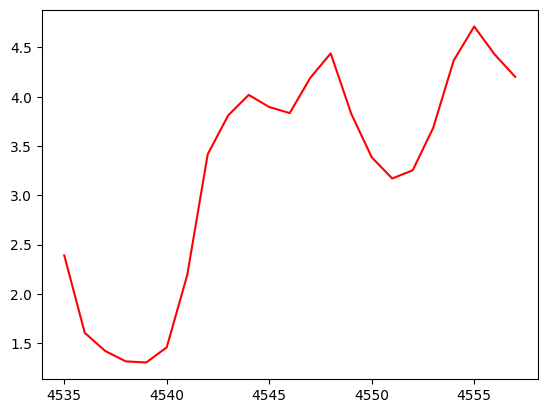

In [9]:
plt.plot(data.index[4535:4558], data["LastprofilHauhalt 35000kWh/Jahr"][4535:4558], color='r') #tag im sommer: 09.07.21

In [7]:
#plt.plot(data.index, data["LastprofilHauhalt 3500kWh/Jahr"], color='r') #3 tage im winter: 1.1. bis 3.1.

In [8]:
#plt.plot(data.index[1:72], data["LastprofilHauhalt 3500kWh/Jahr"][1:72], color='r') #3 tage im winter: 1.1. bis 3.1.

In [13]:
#data = pd.DataFrame(data['LastprofilHauhalt 3500kWh/Jahr'].round(2))
#data

In [10]:
data['LastprofilHauhalt 35000kWh/Jahr'].to_csv("data/LastprofilHaushalt.csv", index=False, header=False)

# get Gas Market Prices
Vorgehensweise:
- basierend auf den monatlichen Gaspreisen soll ein Datensatz erstellt werden für stündliche Gaspreise
- hierfür wird für jeden Tag bzw. jede Stunde der jeweilige Monatspreis angenommen


In [2]:
#get monthly prices of gas from 2019 (Source: Statista)
import pandas as pd
import numpy as np
gas_prices = pd.read_csv('../data/raw_data/Ergaspreise_DE_Statista_Monatlich.csv', sep=';')
gas_prices['Preise in euro/kWh'] = gas_prices / 1000 #get prices in kwH
gas_prices

,Preise in euro/MWh,Preise in euro/kWh
0,22.33,0.02233
1,18.81,0.01881
2,16.51,0.01651
3,15.83,0.01583
4,14.12,0.01412
5,10.65,0.01065
6,11.15,0.01115
7,10.32,0.01032
8,9.78,0.00978
9,10.46,0.01046


get dataframe with amount of days in the respective month

In [3]:

import calendar

# Erstelle eine Liste der Monate
months = range(1, 13)

# Erstelle eine leere Liste für die Anzahl der Tage pro Monat
days_in_month = []

# Iteriere über die Monate und erhalte die Anzahl der Tage
for month in months:
    days = calendar.monthrange(2019, month)[1]  # Jahr 2023 verwenden
    days_in_month.append(days)

# Erstelle den DataFrame
df = pd.DataFrame({'Month': calendar.month_name[1:], 'Days': days_in_month})

print(df)

        Month  Days
0     January    31
1    February    28
2       March    31
3       April    30
4         May    31
5        June    30
6        July    31
7      August    31
8   September    30
9     October    31
10   November    30
11   December    31


In [7]:
data = np.array([])  # Initialisiere leeres Array für die Daten

for i in range(12):
    amount_of_days = df.iloc[i]['Days']
    gas_price = gas_prices.iloc[i][1]
    data_month = np.full(amount_of_days*24, gas_price)  # Erhalte stündliche Daten für den Monat
    
    # Speichere das Array 'data_month' in 'data'
    if data.size == 0:
        data = data_month
    else:
        data = np.concatenate((data, data_month))


In [8]:
data

array([0.02233, 0.02233, 0.02233, ..., 0.01363, 0.01363, 0.01363])

In [9]:
#save data as csv
data = pd.DataFrame(data)
data.to_csv("../data/gas_market_prices_2019.csv",index=False, header=False)